## Import Required Packages and Frameworks

In [1]:
from data_reader import csv_importer
from transformation import Transformation
from model import Model
#loan_data = csv_importer('C:/Users/Datasets/LoanPredictionDataset.csv')
transform = Transformation(csv_importer('C:/Users/Datasets/LoanPredictionDataset.csv'))
#transform = Transformation(loan_data)
data = transform.run_pipeline()
model = Model(data)
predicted, actual, accuracy, f1, roc_score, conf_matrix, class_report= model.run_pipeline()
print(predicted[:5])
print(actual.head())
print(f"Accuracy: {accuracy}")
print(f"F-1 Score: {f1}")
print(f"AUC-ROC Score: {roc_score}")
print(conf_matrix)
print(class_report)

The model scored a 1.0 accuracy on the training dataset
The model had a 1.0 F-1 Score on the training dataset
The model had an 1.0 roc_auc_score on the training dataset
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       352
           1       1.00      1.00      1.00       323

    accuracy                           1.00       675
   macro avg       1.00      1.00      1.00       675
weighted avg       1.00      1.00      1.00       675

[[352   0]
 [  0 323]]
The model scored a 0.8224852071005917 accuracy on the test dataset
The model had a 0.84375 F-1 Score on the test dataset
The model had an 0.8233766233766234 roc_auc_score on the test dataset
[0 1 1 1 0]
208    1
149    1
189    1
418    1
211    0
Name: Loan_Status, dtype: int64
Accuracy: 0.8224852071005917
F-1 Score: 0.84375
AUC-ROC Score: 0.8233766233766234
[[58 12]
 [18 81]]
              precision    recall  f1-score   support

           0       0.76      0.83      0.79  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, CategoricalNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

## Import Dataset

In [3]:
from data_reader import csv_importer
loan_data = csv_importer('C:/Users/Datasets/LoanPredictionDataset.csv')
loan_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
loan_data.ApplicantIncome.describe()

count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

In [50]:
# Replace Missing Values in Dataset According to Datatypes (Mode for Categories. Mean for Continuous)
for col in loan_data.columns:
    if loan_data[col].isnull().sum() > 0:
        if loan_data[col].nunique() > 10:
            loan_data[col] = loan_data[col].fillna(loan_data[col].mean())
        else:
            loan_data[col] = loan_data[col].fillna(loan_data[col].mode()[0])

In [51]:
loan_data.index = loan_data['Loan_ID']
loan_data['Total_Income'] = (loan_data.ApplicantIncome + loan_data.CoapplicantIncome)
loan_data['Debt_Income'] = (loan_data.LoanAmount / loan_data.Total_Income)
loan_data['Payment'] = (loan_data.LoanAmount / loan_data.Loan_Amount_Term)
loan_data.drop(columns=['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], inplace=True)

In [52]:
loan_data.Credit_History = loan_data.Credit_History.astype('object') 

In [53]:
# Standardize All Numeric Variables Using a Natural Logarithm Transformation
for col in loan_data.columns:
    if loan_data[col].dtypes in ['int64', 'float64']:
        loan_data[col] =  np.log(loan_data[col])      

In [54]:
# Plotting Numeric Feature Distributions
def num_distribution(df, column):
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=column, kde=True)
    plt.title(column + ' Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [55]:
# Plotting Categorical Feature Distributions
def cat_distribution(df, column):
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=column, palette="flare")
    plt.title(column + ' Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

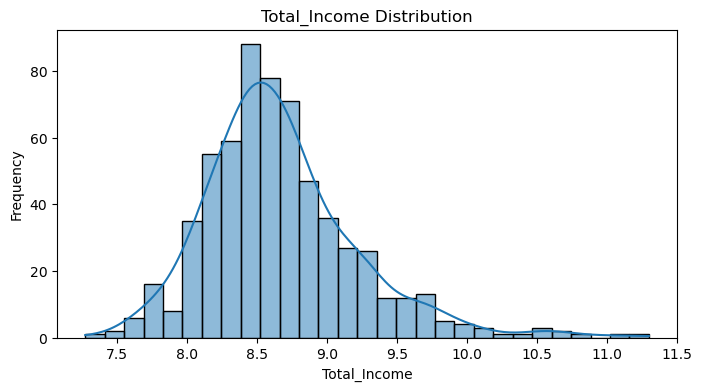

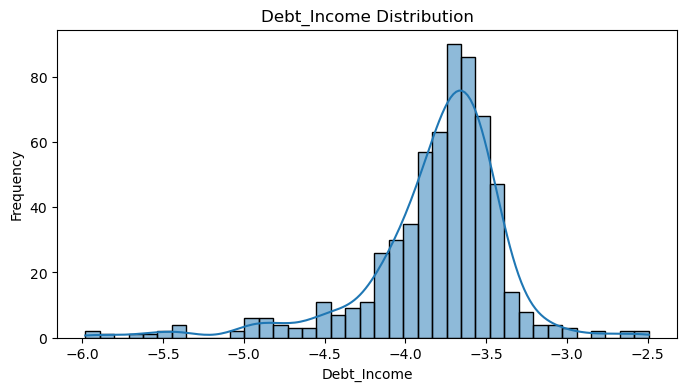

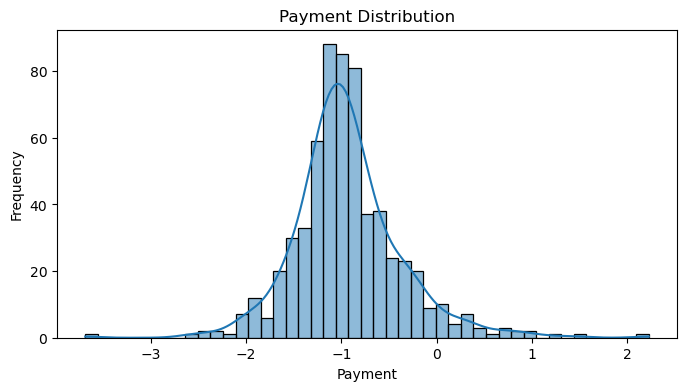

In [56]:
num_cols = list(loan_data.select_dtypes(exclude=['object']).columns)
for col in num_cols:
    num_distribution(loan_data, col)

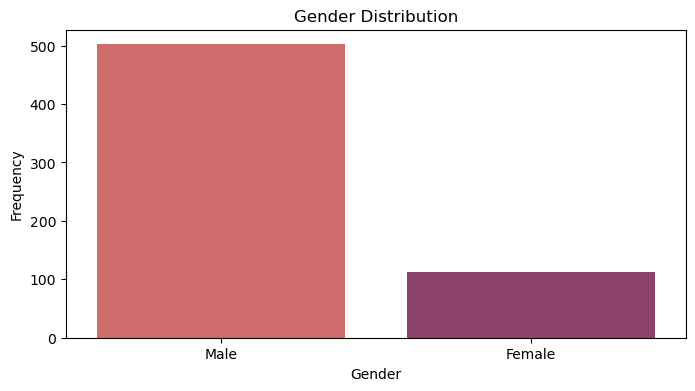

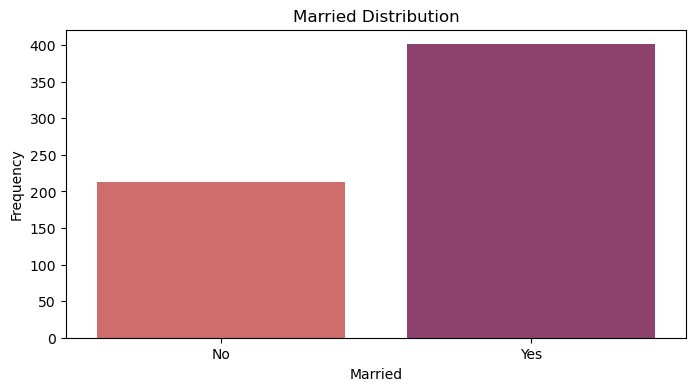

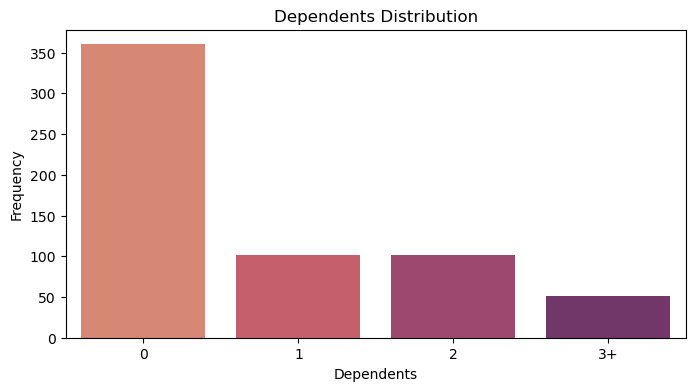

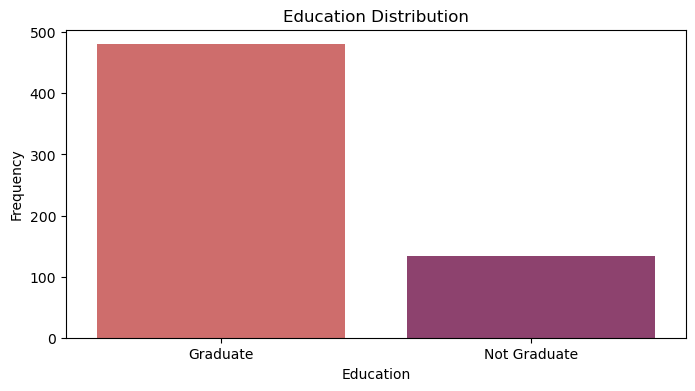

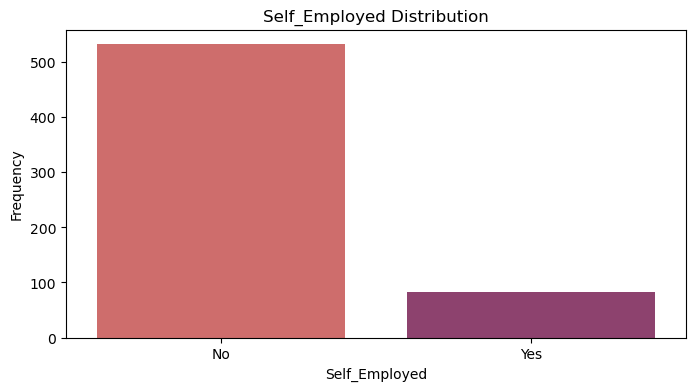

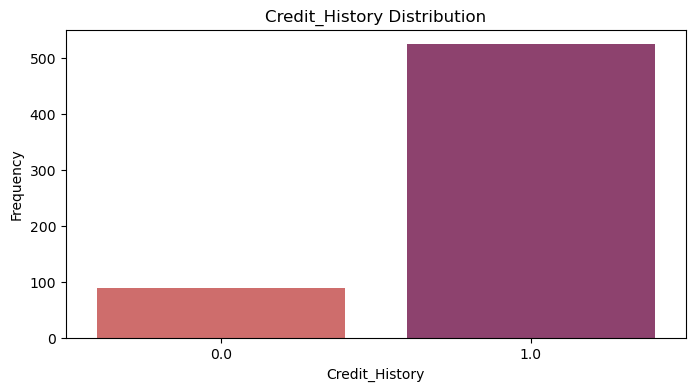

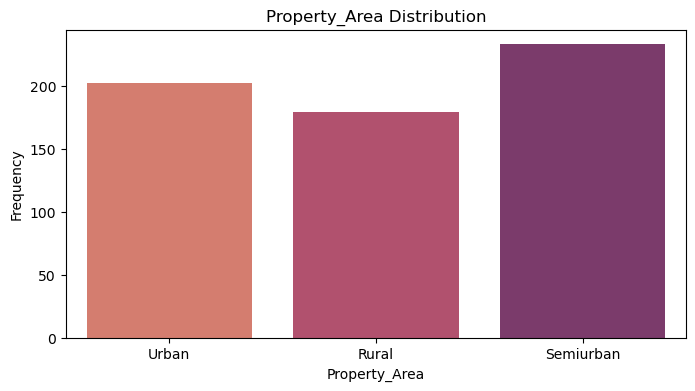

In [57]:
cat_cols = list(loan_data.drop(columns=['Loan_Status']).select_dtypes(include=['object']).columns)
for col in cat_cols:
    cat_distribution(loan_data, col)

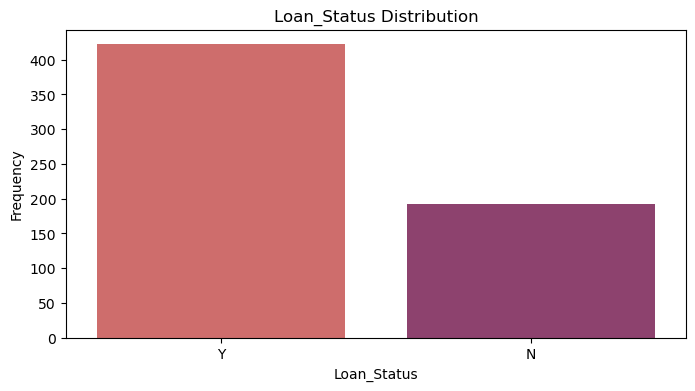

In [58]:
cat_distribution(loan_data, 'Loan_Status')

In [59]:
loan_data.dtypes

Gender             object
Married            object
Dependents         object
Education          object
Self_Employed      object
Credit_History     object
Property_Area      object
Loan_Status        object
Total_Income      float64
Debt_Income       float64
Payment           float64
dtype: object

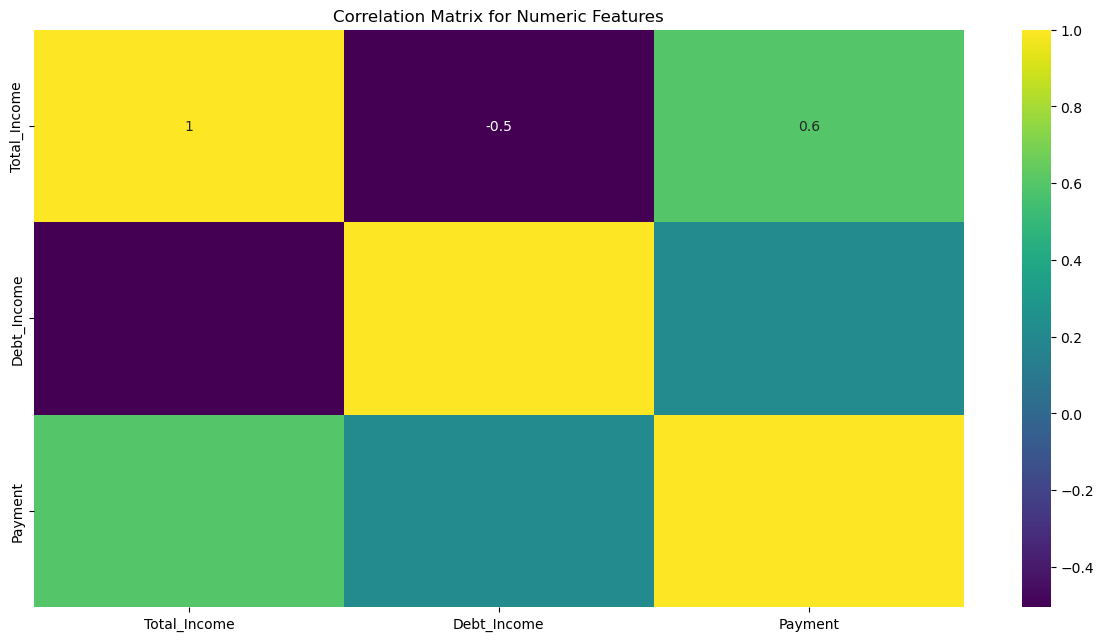

In [60]:
corr_matrix = loan_data.corr(numeric_only=True)

# Create a heatmap figure with specified size (in inches)
plt.figure(figsize=(15, 7.5))

# Generate a heatmap to visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='viridis')

# Add a title to the plot
plt.title('Correlation Matrix for Numeric Features')

# Display the heatmap
plt.show()

In [61]:
le = LabelEncoder()
for col in cat_cols:
    le.fit(loan_data[col])
    loan_data[col] = le.transform(loan_data[col])

In [62]:
target_map = {'Y':1, 'N':0}
reverse_target_map = {1: 'Y', 0: 'N' }
loan_data['Loan_Status'] = loan_data['Loan_Status'].map(target_map)

In [63]:
# Get the Target and Feature variables
X = loan_data.drop('Loan_Status', axis = 1)
y = loan_data['Loan_Status']

In [64]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          614 non-null    int32  
 1   Married         614 non-null    int32  
 2   Dependents      614 non-null    int32  
 3   Education       614 non-null    int32  
 4   Self_Employed   614 non-null    int32  
 5   Credit_History  614 non-null    int32  
 6   Property_Area   614 non-null    int32  
 7   Loan_Status     614 non-null    int64  
 8   Total_Income    614 non-null    float64
 9   Debt_Income     614 non-null    float64
 10  Payment         614 non-null    float64
dtypes: float64(3), int32(7), int64(1)
memory usage: 56.9+ KB


## Data Oversampling Due to Target Imbalance

In [65]:
# Print original class distribution
print('Original class distribution:')
print('Class 0:', np.bincount(y)[0], 'Class 1:', np.bincount(y)[1])

# Initialize SMOTENC specifying which features are categorical
smote_nc = SMOTENC(categorical_features=cat_cols, random_state=42)

# Perform the resampling
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

# Print the resampled data size and class distribution
print('Resampled class distribution:')
print('Class 0:', np.bincount(y_resampled)[0], 'Class 1:', np.bincount(y_resampled)[1])

Original class distribution:
Class 0: 192 Class 1: 422
Resampled class distribution:
Class 0: 422 Class 1: 422


In [66]:
# Split the dataset to training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.20, random_state = 420)

## Random Forest Classifier

### Tuning Using Random Grid

In [67]:
# Fit Best Random Grid Parameters (Original Fitting Removed)
rf_random = RandomForestClassifier(criterion='log_loss', n_estimators=2000,min_samples_split=10, min_samples_leaf=4,max_features='auto',max_depth=100,bootstrap=False, random_state=420)
rf_random.fit(X_train, y_train)

# Get the Price Prediction on the Training Data
predictions = rf_random.predict(X_train)
acc = accuracy_score(y_train, predictions)
print(f"The model scored {acc} accuracy on the training dataset")

# Get the Prediction Accuracy on the Test Data
predictions = rf_random.predict(X_test)
acc = accuracy_score(y_test, predictions)
print(f"The model scored {acc} accuracy on the test dataset")

print(classification_report(y_test, predictions))

confusion_matrix(y_test, predictions)

auc = roc_auc_score(y_test, predictions)
print("Auc for our sample data is {}".format(auc))

The model scored 0.9703703703703703 accuracy on the training dataset
The model scored 0.8106508875739645 accuracy on the test dataset
              precision    recall  f1-score   support

           0       0.79      0.74      0.76        70
           1       0.83      0.86      0.84        99

    accuracy                           0.81       169
   macro avg       0.81      0.80      0.80       169
weighted avg       0.81      0.81      0.81       169

Auc for our sample data is 0.8007215007215007


### Tuning Using Grid Search

In [68]:
# Fit Best Random Grid Parameters (Original Fitting Removed)
rf_grid = RandomForestClassifier(criterion='log_loss', bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12,n_estimators=100, random_state=42)
rf_grid.fit(X_train, y_train)

# Get the Price Prediction on the Training Data
predictions = rf_grid.predict(X_train)
acc = accuracy_score(y_train, predictions)
print(f"The model scored {acc} accuracy on the training dataset")

# Get the Prediction Accuracy on the Test Data
predictions = rf_grid.predict(X_test)
acc = accuracy_score(y_test, predictions)
print(f"The model scored {acc} accuracy on the test dataset")

print(classification_report(y_test, predictions))
confusion_matrix(y_test, predictions)
auc = roc_auc_score(y_test, predictions)

The model scored 0.8977777777777778 accuracy on the training dataset
The model scored 0.7751479289940828 accuracy on the test dataset
              precision    recall  f1-score   support

           0       0.74      0.71      0.72        70
           1       0.80      0.82      0.81        99

    accuracy                           0.78       169
   macro avg       0.77      0.77      0.77       169
weighted avg       0.77      0.78      0.77       169

Auc for our sample data is 0.7662337662337664


### No Tuning of Hyperparameters

In [69]:
# Create an instance for our model
#model = RandomForestClassifier(random_state=42)
model = LogisticRegressionCV()
model.fit(X_train, y_train)

# Get the Price Prediction on the Training Data
predictions = model.predict(X_train)
acc = accuracy_score(y_train, predictions)
print(f"The model scored {acc} accuracy on the training dataset")

# Get the Prediction Accuracy on the Test Data
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print(f"The model scored {acc} accuracy on the test dataset")

print(classification_report(y_test, predictions))

confusion_matrix(y_test, predictions)

auc = roc_auc_score(y_test, predictions)
print("Auc for our sample data is {}".format(auc))

The model scored 0.7066666666666667 accuracy on the training dataset
The model scored 0.7396449704142012 accuracy on the test dataset
              precision    recall  f1-score   support

           0       0.82      0.47      0.60        70
           1       0.71      0.93      0.81        99

    accuracy                           0.74       169
   macro avg       0.77      0.70      0.70       169
weighted avg       0.76      0.74      0.72       169

Auc for our sample data is 0.7003607503607503


## Decision Tree Classifier

In [265]:
# Instantiate Decision Tree Classifier Model and Create HyperParameter Grid
model = DecisionTreeClassifier(random_state = 42)

param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10, 15], 
              'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4] }

# Tune Hyperparameters Using GridSearch
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train) 
best_params = grid_search.best_params_ 
print("Best Parameters:", best_params)

# Use Best Hyperparameters
best_model = grid_search.best_estimator_ 
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy') 
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

# Select the Best Estimator to Fit Training Data
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_train, y_train)
print(f" Training Accuracy: {accuracy}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Cross-Validation Scores: [0.74074074 0.68888889 0.73333333 0.74814815 0.72592593]
Mean CV Accuracy: 0.7274074074074074
 Training Accuracy: 0.7777777777777778


In [266]:
# Use Trained Model on Test Dataset and Reverse Label Predictions
y_predict = best_model.predict(X_test)
acc = accuracy_score(y_test, y_predict)
acc

0.757396449704142

In [70]:
importances = rf_random.feature_importances_
feature_names = X_train.columns
feature_importances = dict(zip(feature_names, importances))

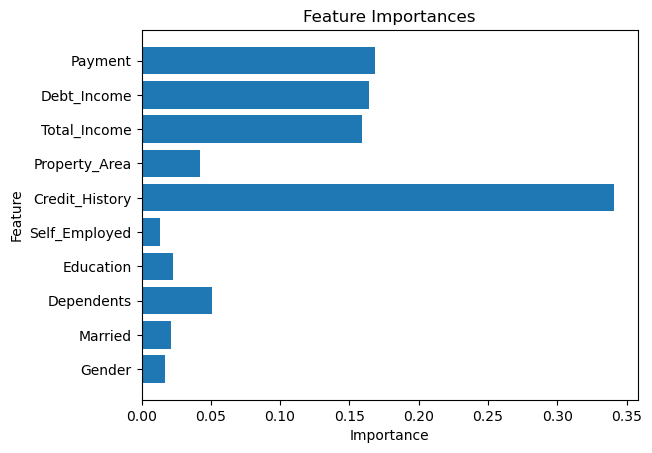

In [71]:
# Visualization of the Most Important Determinants of Survival
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()